In [1]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Import your JordanRNN model
# from models import JordanRNN


In [30]:
def simulate_time_series(n_steps, seasonality_period, noise_level=0.1, seed=42):
    np.random.seed(seed)  # For reproducibility
    trend = np.linspace(0, 10, n_steps)
    seasonality = np.sin(np.linspace(0, 2 * np.pi * (n_steps / seasonality_period), n_steps))
    noise = np.random.normal(0, noise_level, n_steps)
    return trend + seasonality + noise

n_steps = 10000
seasonality_period = 50
time_series_data = simulate_time_series(n_steps, seasonality_period)


In [31]:
time_series_data = np.diff(time_series_data)

In [33]:
time_series_data

array([0.06284796, 0.20296391, 0.20797961, ..., 0.2497483 , 0.24447686,
       0.14120809])

In [34]:
import pandas as pd
df = pd.DataFrame({
    'Time': range(1, len(time_series_data) + 1),
    'Amount': time_series_data
})

df.head()

,Time,Amount
0,1,0.062848
1,2,0.202964
2,3,0.207980
3,4,-0.061080
4,5,0.107040


In [ ]:
def train_validate_test_split(data, train_size=0.7, val_size=0.15):
    n = len(data)
    train_end = int(n * train_size)
    val_end = int(n * (train_size + val_size))
    train_data = data[:train_end]
    val_data = data[train_end:val_end]
    test_data = data[val_end:]
    return train_data, val_data, test_data

train_data, val_data, test_data = train_validate_test_split(time_series_data)


In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(train_data.reshape(-1, 1))

scaled_train_data = scaler.transform(train_data.reshape(-1, 1)).flatten()
scaled_val_data = scaler.transform(val_data.reshape(-1, 1)).flatten()
scaled_test_data = scaler.transform(test_data.reshape(-1, 1)).flatten()


In [ ]:
def create_sequences(data, sequence_length):
    X = []
    y = []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i + sequence_length])
        y.append(data[i + sequence_length])
    return np.array(X), np.array(y)

sequence_length = 50  # You can adjust this value
X_train, y_train = create_sequences(scaled_train_data, sequence_length)
X_val, y_val = create_sequences(scaled_val_data, sequence_length)
X_test, y_test = create_sequences(scaled_test_data, sequence_length)

# Reshape inputs to (batch_size, sequence_length, input_size)
X_train = X_train.reshape(-1, sequence_length, 1)
X_val = X_val.reshape(-1, sequence_length, 1)
X_test = X_test.reshape(-1, sequence_length, 1)

# Reshape targets to (batch_size, 1)
y_train = y_train.reshape(-1, 1)
y_val = y_val.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)



In [ ]:
# Convert to PyTorch tensors
X_train_tensor = torch.from_numpy(X_train).float()
y_train_tensor = torch.from_numpy(y_train).float()
X_val_tensor = torch.from_numpy(X_val).float()
y_val_tensor = torch.from_numpy(y_val).float()
X_test_tensor = torch.from_numpy(X_test).float()
y_test_tensor = torch.from_numpy(y_test).float()

# Create datasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Create data loaders
batch_size = 64  # Adjust as needed

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [ ]:
input_size = 1  # Univariate time series
hidden_size = 64  # Adjust as needed
output_size = 1
num_layers = 1
learning_rate = 0.01
num_epochs = 20

model_jordan = JordanRNN(input_size, hidden_size, output_size, num_layers)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model_jordan.parameters(), lr=learning_rate)

In [ ]:
print(f'Scaled Train Data Mean: {scaled_train_data.mean()}, Std: {scaled_train_data.std()}')

In [ ]:
# def create_sequences(data, seq_length):
#     xs = []
#     ys = []
#     for i in range(len(data) - seq_length):
#         x = data[i:(i+seq_length)]
#         y = data[i+seq_length]
#         xs.append(x)
#         ys.append(y)
#     return np.array(xs), np.array(ys)

def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs, patience):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    best_val_loss = float('inf')
    patience_counter = 0
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for batch_x, batch_y in train_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            optimizer.zero_grad()
            outputs = model(batch_x)
            loss = criterion(outputs[:, -1, :], batch_y)
            loss.backward()
            
            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            optimizer.step()
            train_loss += loss.item()

            # Print parameter norms and gradients
            if epoch == 0:
                for name, param in model.named_parameters():
                    if param.grad is not None:
                        print(f"{name} - grad norm: {param.grad.norm().item():.4f}")
                        print(f"{name} - param norm: {param.norm().item():.4f}")

        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        val_loss = validate(model, val_loader, criterion, device)
        val_losses.append(val_loss)
        
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

        scheduler.step(val_loss)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), 'best_jordan_model.pth')
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping!")
                break

    return train_losses, val_losses

def validate(model, val_loader, criterion, device):
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch_x, batch_y in val_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            outputs = model(batch_x)
            loss = criterion(outputs[:, -1, :], batch_y)
            val_loss += loss.item()
    return val_loss / len(val_loader)

def predict(model, test_loader, device):
    model.eval()
    predictions = []
    actuals = []
    with torch.no_grad():
        for batch_x, batch_y in test_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            outputs = model(batch_x)
            predictions.extend(outputs[:, -1, :].cpu().numpy())
            actuals.extend(batch_y.cpu().numpy())
    return np.array(predictions), np.array(actuals)

In [ ]:
# Load the best model weights
model_jordan.load_state_dict(torch.load('best_jordan_model.pth'))

In [ ]:
def predict(model, data_loader):
    model.eval()
    predictions = []
    actuals = []
    with torch.no_grad():
        for X_batch, y_batch in data_loader:
            output = model(X_batch)
            predictions.extend(output.numpy())
            actuals.extend(y_batch.numpy())
    return np.array(predictions), np.array(actuals)
predictions, actuals = predict(model_jordan, test_loader)

In [ ]:
# Reshape for inverse transform
predictions = predictions.reshape(-1, 1)
actuals = actuals.reshape(-1, 1)

# Inverse transform using the scaler
predictions_inv_scaled = scaler.inverse_transform(predictions)
actuals_inv_scaled = scaler.inverse_transform(actuals)


In [ ]:
# Initialize lists to store the inverted predictions and actuals
predictions_inv = []
actuals_inv = []

# Get the initial values from the original (non-differenced) test data
# Since differencing reduces the data length by 1, we need to offset by 1
initial_value = test_data[sequence_length - 1]

# Reconstruct the original values
cumulative_sum_pred = initial_value
cumulative_sum_act = initial_value

for pred_diff, act_diff in zip(predictions_inv_scaled.flatten(), actuals_inv_scaled.flatten()):
    cumulative_sum_pred += pred_diff
    cumulative_sum_act += act_diff
    predictions_inv.append(cumulative_sum_pred)
    actuals_inv.append(cumulative_sum_act)

predictions_inv = np.array(predictions_inv)
actuals_inv = np.array(actuals_inv)


In [ ]:
mse = mean_squared_error(actuals_inv, predictions_inv)
mae = mean_absolute_error(actuals_inv, predictions_inv)
print(f'Test MSE: {mse:.4f}, Test MAE: {mae:.4f}')


In [ ]:
plt.figure(figsize=(15, 5))
plt.plot(actuals_inv, label='Actual')
plt.plot(predictions_inv, label='Predicted')
plt.legend()
plt.title('Jordan RNN Predictions vs Actuals')
plt.show()

# V2

In [29]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import time
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings("ignore")


# Define the three RNNs (Elman, Jordan, Multi-layer RNNs)
class ElmanRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1, dropout=0.0):
        super(ElmanRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers=num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)  # Initial hidden state
        out, hn = self.rnn(x, h0)  # Passing the input and initial hidden state
        out = self.fc(out[:, -1, :])  # Take the output at the last time step
        return out


class JordanRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1, dropout=0.0):
        super(JordanRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.input_size = input_size
        self.rnn = nn.RNN(self.input_size + 1, hidden_size, num_layers=num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # x shape: (batch_size, sequence_length, input_size)
        batch_size = x.size(0)
        sequence_length = x.size(1)
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size)  # Initial hidden state

        # Initial output placeholder: output shape (batch_size, 1, 1) -> scalar per sequence at each time step
        output = torch.zeros(batch_size, 1, 1)  # Placeholder for previous output

        for t in range(sequence_length):
            # Concatenate the input at timestep t with the previous output
            combined_input = torch.cat((x[:, t : t + 1, :], output), dim=2)  # Concatenate input and previous output along feature axis

            # Pass through RNN
            out, h0 = self.rnn(combined_input, h0)

            # Generate the new output
            output = self.fc(out)  # Pass RNN output through the fully connected layer to get the prediction

        return output  # Return the last output after looping through all timesteps


class MultiRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dropout=0.0):
        super(MultiRNN, self).__init__()
        self.hidden_size = hidden_size
        self.input_size = input_size
        self.output_size = output_size

        # RNNCell allows more granular control over the inputs at each time step
        self.rnn_cell = nn.RNNCell(input_size + output_size, hidden_size)
        self.fc = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x):
        # x shape: (batch_size, sequence_length, input_size)
        batch_size, sequence_length, _ = x.size()

        # Initialize hidden state and previous output
        h_t = torch.zeros(batch_size, self.hidden_size).to(x.device)
        y_t_prev = torch.zeros(batch_size, self.output_size).to(x.device)

        outputs = []

        for t in range(sequence_length):
            x_t = x[:, t, :]  # Current input at time t
            combined_input = torch.cat([x_t, y_t_prev], dim=1)  # Shape: (batch_size, input_size + output_size)
            h_t = self.rnn_cell(combined_input, h_t)  # Shape: (batch_size, hidden_size)
            h_t_drop = self.dropout(h_t)
            y_t = self.fc(h_t_drop)  # Shape: (batch_size, output_size)
            outputs.append(y_t.unsqueeze(1))  # Shape: (batch_size, 1, output_size)
            # Update previous output for next time step
            y_t_prev = y_t

        # Concatenate all outputs if sequence output is desired
        outputs = torch.cat(outputs, dim=1)  # Shape: (batch_size, sequence_length, output_size)

        return y_t  # Shape: (batch_size, output_size)


def create_sequences(data, target, window_size):
    sequences = []
    labels = []
    for i in range(len(data) - window_size):
        sequences.append(data[i : i + window_size])
        labels.append(target[i + window_size])
    return np.array(sequences), np.array(labels)


# Function to train and evaluate the RNN model with improvements
def train_and_evaluate(model, X_train, y_train, X_test, y_test, epochs=20, patience=5, batch_size=32):
    # Convert to PyTorch tensors
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

    # Define loss and optimizer
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, "min", patience=5, factor=0.5)

    best_mse = float("inf")
    patience_counter = 0
    num_batches = X_train_tensor.size(0) // batch_size

    # Training loop with early stopping, learning rate scheduler, and batch processing
    for epoch in range(epochs):
        model.train()
        for i in range(num_batches):
            start = i * batch_size
            end = start + batch_size
            X_batch = X_train_tensor[start:end]
            y_batch = y_train_tensor[start:end]
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs.flatten(), y_batch)
            loss.backward()
            optimizer.step()

        # Checkpointing and early stopping logic
        model.eval()
        with torch.no_grad():
            predictions = model(X_test_tensor).flatten()
            mse = mean_squared_error(y_test_tensor, predictions)
            scheduler.step(mse)  # Update learning rate based on the validation loss

            if mse < best_mse:
                best_mse = mse
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print(f"Early stopping at epoch {epoch} with best MSE: {best_mse}")
                    break

    return best_mse


# Predicting and comparing on the last test set
def plot_predictions(last_X_test, last_y_test, last_model):
    if last_X_test is not None and last_y_test is not None and last_model is not None:
        last_X_test_1 = last_X_test
        last_y_test_1 = last_y_test
        print("\nPredicting on the last test set with the trained Elman RNN...")
        last_model.eval()
        with torch.no_grad():
            predictions_scaled = last_model(torch.tensor(last_X_test_1, dtype=torch.float32)).flatten().numpy()

        # Print predicted and actual values in scaled form
        print("\nScaled Predicted vs Actual values:")
        for pred_scaled, actual_scaled in zip(predictions_scaled, last_y_test_1):
            print(f"Scaled Predicted: {pred_scaled:.4f}, Scaled Actual: {float(actual_scaled):.4f}")

        # Plotting the scaled predictions vs actuals
        plt.figure(figsize=(20, 6))  # Wide figure
        plt.plot(last_y_test_1, "r-", marker="x", label="Scaled Actual")
        plt.plot(predictions_scaled, "b-", marker="o", label="Scaled Predicted")
        plt.title("Scaled Predictions vs Actuals")
        plt.xlabel("Sample Index")
        plt.ylabel("Value")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.suptitle("Scaled Predictions vs Actuals Comparison", fontsize=16)
        plt.subplots_adjust(top=0.88)
        plt.show()

--------------------------------------------
Training Elman RNN...
Start training Elman RNN fold 0
Early stopping at epoch 5 with best MSE: 0.02106667309999466
Elman RNN MSE (Fold 0): 0.02106667309999466
Elman RNN training time: 0.57 seconds
Start training Elman RNN fold 1
Early stopping at epoch 13 with best MSE: 0.02102028951048851
Elman RNN MSE (Fold 1): 0.02102028951048851
Elman RNN training time: 2.59 seconds
Start training Elman RNN fold 2
Early stopping at epoch 6 with best MSE: 0.019304942339658737
Elman RNN MSE (Fold 2): 0.019304942339658737
Elman RNN training time: 1.83 seconds
Start training Elman RNN fold 3
Early stopping at epoch 8 with best MSE: 0.01760457456111908
Elman RNN MSE (Fold 3): 0.01760457456111908
Elman RNN training time: 3.07 seconds

Predicting on the last test set with the trained Elman RNN...

Scaled Predicted vs Actual values:
Scaled Predicted: 0.4824, Scaled Actual: 0.5575
Scaled Predicted: 0.4824, Scaled Actual: 0.4434
Scaled Predicted: 0.4824, Scaled Ac

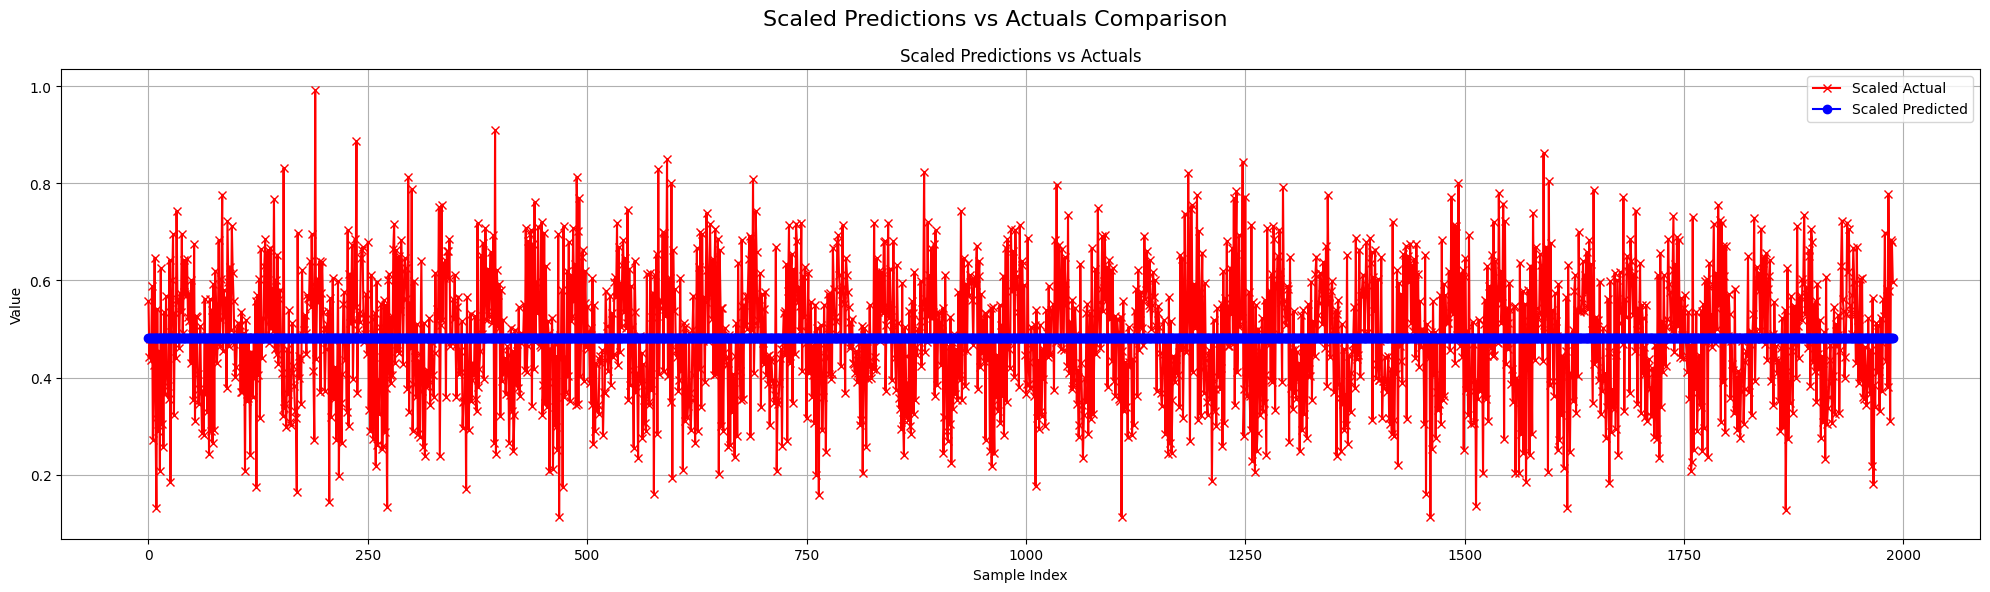

--------------------------------------------
Training Jordan RNN...
Start training Jordan RNN fold 0
Early stopping at epoch 5 with best MSE: 0.02135428413748741
Jordan RNN MSE (Fold 0): 0.02135428413748741
Jordan RNN training time: 1.07 seconds
Start training Jordan RNN fold 1
Early stopping at epoch 9 with best MSE: 0.021020064130425453
Jordan RNN MSE (Fold 1): 0.021020064130425453
Jordan RNN training time: 3.26 seconds
Start training Jordan RNN fold 2
Early stopping at epoch 7 with best MSE: 0.019246621057391167
Jordan RNN MSE (Fold 2): 0.019246621057391167
Jordan RNN training time: 3.74 seconds
Start training Jordan RNN fold 3
Early stopping at epoch 10 with best MSE: 0.017604442313313484
Jordan RNN MSE (Fold 3): 0.017604442313313484
Jordan RNN training time: 6.64 seconds

Predicting on the last test set with the trained Elman RNN...

Scaled Predicted vs Actual values:
Scaled Predicted: 0.4822, Scaled Actual: 0.5575
Scaled Predicted: 0.4822, Scaled Actual: 0.4434
Scaled Predicted: 

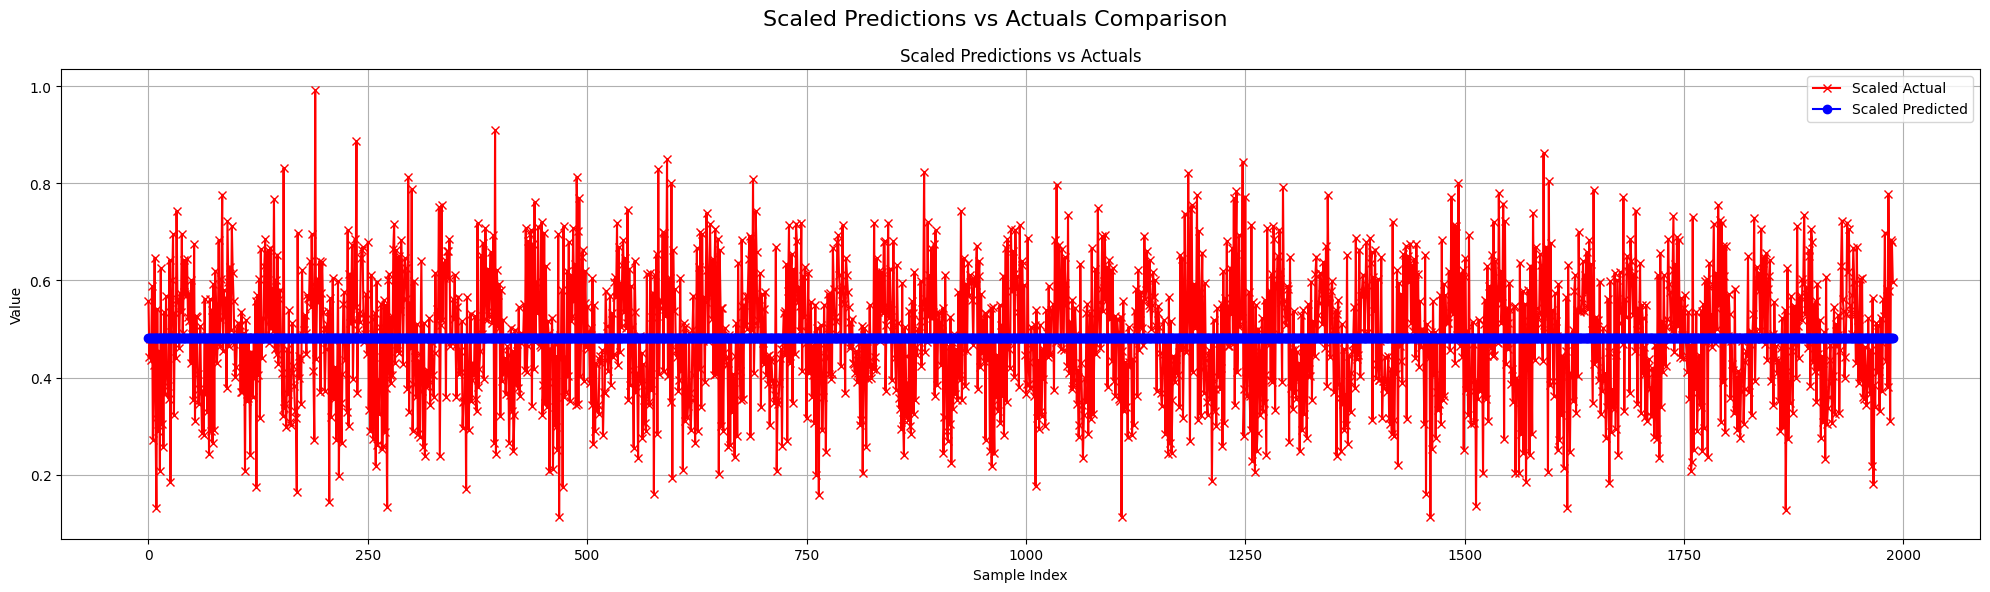

--------------------------------------------
Training Multi-layer RNN...
Start training Multi-layer RNN fold 0
Early stopping at epoch 8 with best MSE: 0.021396247670054436
Multi-layer RNN MSE (Fold 0): 0.021396247670054436
Multi-layer RNN training time: 1.21 seconds
Start training Multi-layer RNN fold 1
Early stopping at epoch 10 with best MSE: 0.02102024480700493
Multi-layer RNN MSE (Fold 1): 0.02102024480700493
Multi-layer RNN training time: 2.88 seconds
Start training Multi-layer RNN fold 2
Early stopping at epoch 5 with best MSE: 0.019246669486165047
Multi-layer RNN MSE (Fold 2): 0.019246669486165047
Multi-layer RNN training time: 2.26 seconds
Start training Multi-layer RNN fold 3
Early stopping at epoch 5 with best MSE: 0.017605848610401154
Multi-layer RNN MSE (Fold 3): 0.017605848610401154
Multi-layer RNN training time: 2.83 seconds

Predicting on the last test set with the trained Elman RNN...

Scaled Predicted vs Actual values:
Scaled Predicted: 0.4822, Scaled Actual: 0.5575
S

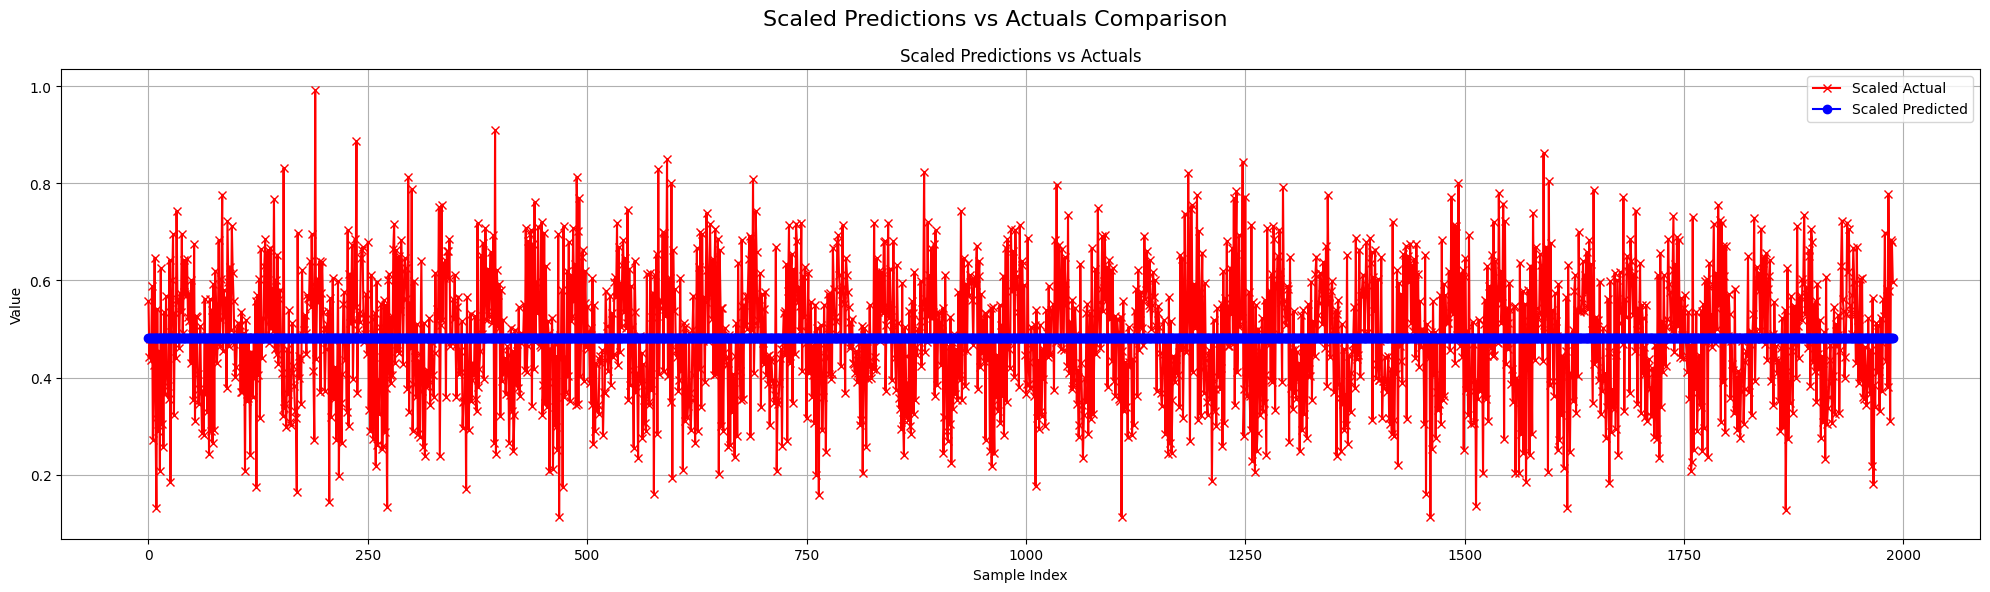

In [35]:
df = df
input_columns = ['Time']
target_column = 'Amount'
warnings.filterwarnings("ignore")

# Set window size (how many timesteps to include in each sequence)
window_size = 10  # Example window size

# Initialize TimeSeriesSplit for cross-validation
tscv = TimeSeriesSplit(n_splits=4)
last_X_test, last_y_test, last_model = None, None, None

# Train and evaluate all folds for Elman RNN first
print("--------------------------------------------")
print("Training Elman RNN...")
for fold, (train_index, test_index) in enumerate(tscv.split(df)):
    # Split the raw data
    df_train, df_test = df.iloc[train_index], df.iloc[test_index]

    # Fit scalers on training data only
    feature_scaler = MinMaxScaler()
    target_scaler = MinMaxScaler()

    # Scale features and target
    X_train_scaled = feature_scaler.fit_transform(df_train[input_columns])
    X_test_scaled = feature_scaler.transform(df_test[input_columns])

    y_train_scaled = target_scaler.fit_transform(df_train[[target_column]])
    y_test_scaled = target_scaler.transform(df_test[[target_column]])

    # Create sequences
    X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, window_size)
    X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled, window_size)

    # Initialize and train Elman RNN
    print(f"Start training Elman RNN fold {fold}")
    start_time = time.time()
    elman_model = ElmanRNN(input_size=X_train_seq.shape[2], hidden_size=50, output_size=1, num_layers=1, dropout=0.0)
    elman_mse = train_and_evaluate(elman_model, X_train_seq, y_train_seq, X_test_seq, y_test_seq)
    end_time = time.time()
    elman_training_time = end_time - start_time
    print(f"Elman RNN MSE (Fold {fold}): {elman_mse}")
    print(f"Elman RNN training time: {elman_training_time:.2f} seconds")

    if fold == tscv.n_splits - 1:
        last_X_test, last_y_test, last_model = X_test_seq, y_test_seq, elman_model
        plot_predictions(last_X_test, last_y_test, last_model)

# Train and evaluate all folds for Jordan RNN
print("--------------------------------------------")
print("Training Jordan RNN...")
for fold, (train_index, test_index) in enumerate(tscv.split(df)):
    # Split the raw data
    df_train, df_test = df.iloc[train_index], df.iloc[test_index]

    # Fit scalers on training data only
    feature_scaler = MinMaxScaler()
    target_scaler = MinMaxScaler()

    # Scale features and target
    X_train_scaled = feature_scaler.fit_transform(df_train[input_columns])
    X_test_scaled = feature_scaler.transform(df_test[input_columns])

    y_train_scaled = target_scaler.fit_transform(df_train[[target_column]])
    y_test_scaled = target_scaler.transform(df_test[[target_column]])

    # Create sequences
    X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, window_size)
    X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled, window_size)

    # Initialize and train Jordan RNN
    print(f"Start training Jordan RNN fold {fold}")
    start_time = time.time()
    jordan_model = JordanRNN(input_size=X_train_seq.shape[2], hidden_size=50, output_size=1, num_layers=1, dropout=0.0)
    jordan_mse = train_and_evaluate(jordan_model, X_train_seq, y_train_seq, X_test_seq, y_test_seq)
    end_time = time.time()
    jordan_training_time = end_time - start_time
    print(f"Jordan RNN MSE (Fold {fold}): {jordan_mse}")
    print(f"Jordan RNN training time: {jordan_training_time:.2f} seconds")

    if fold == tscv.n_splits - 1:
        last_X_test, last_y_test, last_model = X_test_seq, y_test_seq, jordan_model
        plot_predictions(last_X_test, last_y_test, last_model)

# Train and evaluate all folds for Multi-layer RNN
print("--------------------------------------------")
print("Training Multi-layer RNN...")
for fold, (train_index, test_index) in enumerate(tscv.split(df)):
    # Split the raw data
    df_train, df_test = df.iloc[train_index], df.iloc[test_index]

    # Fit scalers on training data only
    feature_scaler = MinMaxScaler()
    target_scaler = MinMaxScaler()

    # Scale features and target
    X_train_scaled = feature_scaler.fit_transform(df_train[input_columns])
    X_test_scaled = feature_scaler.transform(df_test[input_columns])

    y_train_scaled = target_scaler.fit_transform(df_train[[target_column]])
    y_test_scaled = target_scaler.transform(df_test[[target_column]])

    # Create sequences
    X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, window_size)
    X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled, window_size)

    # Initialize and train Multi-layer RNN
    print(f"Start training Multi-layer RNN fold {fold}")
    start_time = time.time()
    multi_rnn_model = MultiRNN(input_size=X_train_seq.shape[2], hidden_size=50, output_size=1, dropout=0.0)
    multi_rnn_mse = train_and_evaluate(multi_rnn_model, X_train_seq, y_train_seq, X_test_seq, y_test_seq)
    end_time = time.time()
    multi_rnn_training_time = end_time - start_time
    print(f"Multi-layer RNN MSE (Fold {fold}): {multi_rnn_mse}")
    print(f"Multi-layer RNN training time: {multi_rnn_training_time:.2f} seconds")

    if fold == tscv.n_splits - 1:
        last_X_test, last_y_test, last_model = X_test_seq, y_test_seq, multi_rnn_model
        plot_predictions(last_X_test, last_y_test, last_model)